# 5. Neural Network Modelling

In 3.Modelling_and_Hyperparamter_Tuning, I experimented with different classifcation and ensemble methods to help classify hotel review scores. Some performed well, but there was definitely room for improvement, so I wanted to explore a deep learning approach. 

## 5.1 Imports

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import pickle


In [12]:
sns.set_context('poster')

In [13]:
df = pd.read_csv('Data/dataset.csv')

## 5.2 One Hot Encoding Scores Column

For multi-class classifcation using the neural network model, I needed the target variable to be one hot encoded, as the output layer would have 5 nodes, 1 for each score.

In [14]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['score']]).toarray())

df = df.join(enc_df)
df.head()

,hotel_name,review_summary,score,review,0,1,2,3,4
0,Hotel Hilton London Gatwick Airport,Awful...,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,Hilton London Metropole,Terrible,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,Hilton London Euston,Double deposit taken from bank,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,Hilton London Metropole,Super disappointed!,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,Hilton London Metropole,Dissatisfied Hilton gold number,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


In [15]:
df = df.rename(columns={0: "score_1", 1:'score_2',2:'score_3',3:'score_4',4:'score_5'})

In [16]:
df.head()

,hotel_name,review_summary,score,review,score_1,score_2,score_3,score_4,score_5
0,Hotel Hilton London Gatwick Airport,Awful...,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,Hilton London Metropole,Terrible,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,Hilton London Euston,Double deposit taken from bank,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,Hilton London Metropole,Super disappointed!,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,Hilton London Metropole,Dissatisfied Hilton gold number,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


## 5.3 Train Test Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df[['review','review_summary']], 
                                                    df[['score_1','score_2','score_3','score_4','score_5']], 
                                                    test_size=.2, 
                                                    random_state=42)

In [18]:
y_test.to_csv('Data/6.y_test_ohe.csv',index=False)

## 5.4 Add Suffix to the Review Summary to Distinguish the Difference

I wanted the words in the review summary to be separate from the words in the review, as they may have a more or less significant impact. Also new data may not contain a review summary and the model will not accurately reflect the review-only data.

In [19]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')


In [20]:
def add_sum_suffix(text):
    
    token_list = tokenizer.tokenize(text.lower())
    new_text = ''
    for word in token_list:
        word = word + '_sum'
        new_text += word + ' '
        
    return new_text

In [21]:

def text_cleanup(text):
    
    token_list = tokenizer.tokenize(text.lower())
    new_text = ''
    for word in token_list:
        new_text += word + ' '
        
    return new_text

In [22]:
def add_one_argmax_score(x):
    
    x = x+1
    
    return x

In [23]:
def reverse_encode(y_df):
    
    y_df['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)
    for i in range(0,len(y_df)):
        if y_df.iloc[i,-1] == 'score_1':
            y_df.iloc[i,-1] = 1
        elif y_df.iloc[i,-1] == 'score_2':
            y_df.iloc[i,-1] = 2
        elif y_df.iloc[i,-1]== 'score_3':
            y_df.iloc[i,-1] = 3
        elif y_df.iloc[i,-1]== 'score_4':
            y_df.iloc[i,-1] = 4
        elif y_df.iloc[i,-1] == 'score_5':
            y_df.iloc[i,-1]= 5

In [24]:
def conf_matrix(cm):
    
    plt.figure(figsize=(9,7))
    ax = sns.heatmap(cm,
                     annot= True, 
                     fmt = '.4g', 
                     cbar=0,
                     xticklabels=[1,2,3,4,5],
                     yticklabels=[1,2,3,4,5])
    ax.set(xlabel='Predicted', ylabel='True')
    plt.show()

In [25]:
x_train['review_summary_suffixed'] = x_train['review_summary'].apply(add_sum_suffix)
x_test['review_summary_suffixed'] = x_test['review_summary'].apply(add_sum_suffix)

In [26]:
x_train.head()

,review,review_summary,review_summary_suffixed
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum


## 5.5 Removing Punctuation and Tokenizing Review Column

In [27]:
x_train['review_cleaned'] = x_train['review'].apply(text_cleanup)
x_test['review_cleaned'] = x_test['review'].apply(text_cleanup)

In [28]:
x_train.head()

,review,review_summary,review_summary_suffixed,review_cleaned
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum,from arrival at check in where we had great se...
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...,after hours waiting for chosen room booked onl...
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...,the hotel is very well located five minutes wa...
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...,we stayed here a total of nights in april the ...
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum,we recently stayed at hilton gatwick south ter...


## 5.6 Creating a Dictionary With Words That Appear in Reviews and an Index

I created an index for each word in the training review dataset, so when passed through the embedding layer of the neural network there is an indexed number associated with each word.

In [29]:
flat_review = " ".join(x_train['review_cleaned'].values)
flat_review = flat_review.lower().split()

In [30]:
len(flat_review)

733061

In [31]:
flat_review_summary = " ".join(x_train['review_summary_suffixed'].values)
flat_review_summary = flat_review_summary.lower().split()

In [32]:
unique_list = []
for word in flat_review:
    if word not in unique_list:
        unique_list.append(word)
for word in flat_review_summary:
    if word not in unique_list:
        unique_list.append(word)

In [33]:
len(unique_list)

17313

In [34]:
word_index_dict = {}
for i in range(0,len(unique_list)):
    word_index_dict[unique_list[i]] = i
    

I added 4 other items to the dictionary that represented padding, the start of the review, unknown words, and unused words.

In [35]:
word_index_dict = {k:(v+4) for k,v in word_index_dict.items()}
word_index_dict['<PAD>'] = 0
word_index_dict['<START>'] = 1
word_index_dict['<UNK>'] = 2
word_index_dict['<UNUSED>'] = 3

## 5.7 Indexing Words in Reviews Using Dictionary

In [36]:
def index_review_words(text):
    review_word_list = []
    for word in text.lower().split():
        if word in word_index_dict.keys():
            review_word_list.append(word_index_dict[word])
        else:
            review_word_list.append(word_index_dict['<UNK>'])

    return review_word_list 

In [37]:
x_train['preprocessed_review'] = x_train['review_cleaned'].apply(index_review_words)
x_test['preprocessed_review'] = x_test['review_cleaned'].apply(index_review_words)

In [38]:
x_train['preprocessed_review_summary'] = x_train['review_summary_suffixed'].apply(index_review_words)
x_test['preprocessed_review_summary'] = x_test['review_summary_suffixed'].apply(index_review_words)

In [39]:
x_train.head()

,review,review_summary,review_summary_suffixed,review_cleaned,preprocessed_review,preprocessed_review_summary
9048,"From arrival at check in, where we had great s...",Excellent hotel,excellent_sum hotel_sum,from arrival at check in where we had great se...,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[14416, 14417]"
1219,After 3 hours waiting for chosen room booked o...,Don't bother with online check-in,don_sum t_sum bother_sum with_sum online_sum c...,after hours waiting for chosen room booked onl...,"[61, 62, 63, 64, 65, 42, 66, 67, 68, 69, 39, 7...","[14418, 14419, 14420, 14421, 14422, 14423, 14424]"
6901,The hotel is very well located five minutes wa...,"Great location, cozy bar, good service",great_sum location_sum cozy_sum bar_sum good_s...,the hotel is very well located five minutes wa...,"[33, 60, 111, 19, 112, 113, 114, 115, 116, 4, ...","[14425, 14426, 14427, 14428, 14429, 14430]"
5466,We stayed here a total of 3 nights in April 20...,London base for land tour with Globus,london_sum base_sum for_sum land_sum tour_sum ...,we stayed here a total of nights in april the ...,"[10, 144, 145, 22, 146, 25, 147, 8, 148, 33, 7...","[14431, 14432, 14433, 14434, 14435, 14421, 14436]"
6107,We recently stayed at Hilton Gatwick south ter...,Pre and post holiday stays,pre_sum and_sum post_sum holiday_sum stays_sum,we recently stayed at hilton gatwick south ter...,"[10, 172, 144, 6, 173, 174, 175, 176, 33, 49, ...","[14437, 14438, 14439, 14440, 14441]"


## 5.8 Combining Indexed Review Summary and Indexed Review Into a Single Column Called All Preprocessed Review

In [40]:
x_train['all_preprocessed_review'] = x_train['preprocessed_review'] + x_train['preprocessed_review_summary']
x_test['all_preprocessed_review'] = x_test['preprocessed_review'] + x_test['preprocessed_review_summary']

## 5.9 Modelling

### 5.9.1 Add Padding to Reviews and Capping Reviews to Length 250 Words

In [41]:
x_train = sequence.pad_sequences(x_train['all_preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)
x_test = sequence.pad_sequences(x_test['all_preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)

### 5.9.3 Creating and Training Neural Network Model

In [42]:
model = Sequential()
model.add(Embedding(17317,16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dense(5,activation='sigmoid'))

In [43]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.2,random_state=42)

In [45]:
fitModel = model.fit(x_train,y_train,epochs=60,batch_size=250,validation_data=(x_val,y_val),verbose=0)

## 5.10 Testing Model

After looking at accuracy scores for the validation data (0.5568) and the test data (0.5710), we can see the neural network model performs well.

In [46]:
model.evaluate(x_val,y_val)

48/48 [==============================] - 0s 1ms/step - loss: 1.0030 - accuracy: 0.5555


[1.0029680728912354, 0.5554817318916321]

In [47]:
model.evaluate(x_test,y_test)

59/59 [==============================] - 0s 1ms/step - loss: 0.9704 - accuracy: 0.5747


[0.9704474806785583, 0.5746943354606628]

## 5.11 Test Confusion Matrix

In order to create a confusion matrix, I have to reverse one hot encode the scores column and adjust the index for 0-4 back to 1-5.

## 5.11.1 Reverse Encode Target Into One Column for Confusion Matrix

In [48]:
reverse_encode(y_test)

In [49]:
reverse_encode(y_val)

In [50]:
y_test_predicted = add_one_argmax_score(np.argmax(model.predict(x_test),axis=1))

### 5.11.2 Saving Neural Network Preprocessed y Data

In [51]:
y_test.to_csv('Data/6.y_test_nn_df.csv',index=False)
np.save('Data/6.y_test_predicted_array',y_test_predicted)

### 5.11.3 Creating Confusion Matrix for Test Data

The confusion matrix looks better than it did for the previous classification model. I shall compare and discuss this in 6.Revaluation_and_Deployment notebook in further detail.

In [52]:
test = []
another1 = []
for i in y_test['score'].values:
    if i in [0,1,2,3,4,5]:
        test.append(i)
    else:
        another1.append(i)

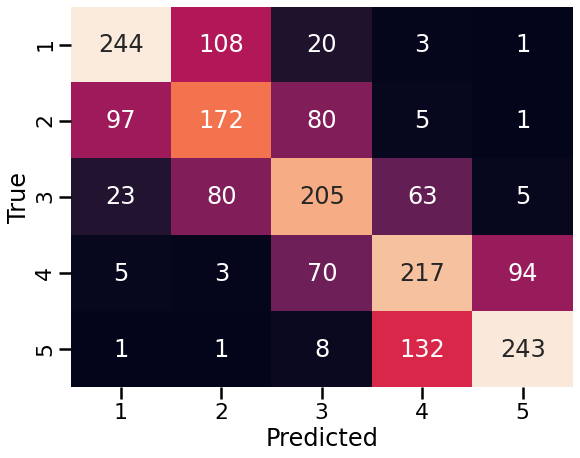

In [53]:
test_cm = confusion_matrix(test, y_test_predicted)
conf_matrix(test_cm)

## **camparision Between Neural network and Machine Learning Models**

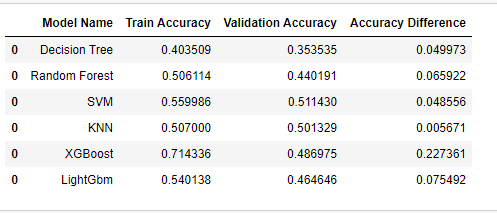

The error is more contained with in adjacent scores with the neural network model. Almost zero confusion between extreme scores 1 and 5, and minimal confusion with scores 2 and 4. Although a score of 3 can be harder to predict, there is definitely an improvement from the Stacking model.

# **5.12 Deployment**
## **5.12.1 Streamlit Application**

I planned on future improvements being the addition of the neural network model and then creating an application for the model, so as a next step I decided to make a working application to test out new reviews using streamlit.

## 5.13 Saving Model


In [54]:
model.save('Models/Neural_Network.h5')

In [56]:
pickle.dump(word_index_dict,open('Data/word_index_dict.pkl','wb'))